In [1]:
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from utils import Manuscript
ms = Manuscript('figures', 2)

## Load and process data

This notebook simply loads the data from an LAS file, and saves the `X` matrix and `y` vectors for training, validation, and testing.

In [2]:
n = 500

In [3]:
from welly import Well

w = Well.from_las("R-39.las")

# Skip the ends of the logs, which have some bad data.
VP = 1e6 / w.data['DT4P'][:-100]
VS = 1e6 / w.data['DT4S'][:-100]
RHO = w.data['RHOB'][:-100]
Z = RHO.basis

# There is some dodgy data in the VS log
VS[VS<0] = np.mean(VS)

# Take every 5th sample, up to the max index n.
vp = VP[::5][:n+1]
vs = VS[::5][:n+1]
rho = RHO[::5][:n+1]
z = Z[::5][:n+1]

# We need (Vp, Vs, rho) for the upper and lower layers of our interfaces.

# Make 'Upper' layers.
vp1 = vp[:-1]
vs1 = vs[:-1]
rho1 = rho[:-1]

# Make 'Lower' layers.
vp2 = vp[1:]
vs2 = vs[1:]
rho2 = rho[1:]

We'll compute the exact Zoeppritz solution for our logs using a lot of random offsets up to 20 degrees. This way, hopefully the network will learn the relationship between rock properties, offset angle, and reflectivity.

Make a random sequence of values to use for the angle of incidence:

In [4]:
np.random.seed(42)
min_theta = 0
max_theta = 20
theta = np.random.random(n) * (max_theta - min_theta) + min_theta

Here's the range of thetas we're going to train on:

In [5]:
np.min(theta), np.max(theta)

(0.10123167692437374, 19.859295922386007)

Now we can make the feature matrix `X`. We make a matrix by stacking all the NumPy arrays, then use Scikit-Learn's `StandardScaler` to scale the features to a zero mean with a standard deviation of 1.

In [6]:
from sklearn.preprocessing import StandardScaler

features = [vp1, vs1, rho1, vp2, vs2, rho2, theta]
X_ = np.stack(features, axis=-1)

scaler = StandardScaler().fit(X_)
X = scaler.transform(X_)

Make the label vector `y`:

In [7]:
from bruges.reflection import zoeppritz_rpp

y_ = [zoeppritz_rpp(*xi[:-1], theta1=xi[-1]) for xi in X_]
y = np.array(y_).real

Some quality checking of `X` and `y`:

In [8]:
print(X.shape, y.shape)

(500, 7) (500,)


Here are the logs and the reflectivity series we're training on:

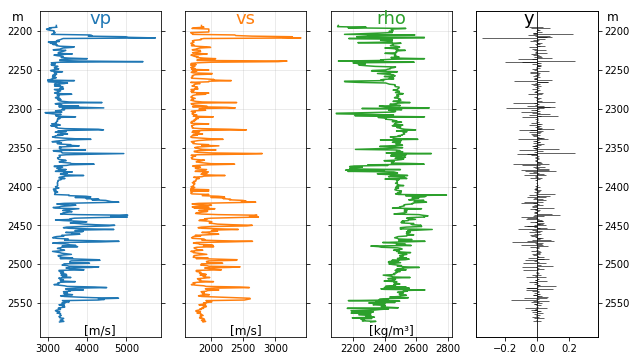

In [9]:
fig, axs = plt.subplots(figsize=(10, 6), ncols=4)

ax = axs[0]
ax.plot(vp, z, c='C0')
ax.invert_yaxis()
ax.yaxis.set_ticks_position('both')
ax.text(np.mean(axs[0].get_xlim()), axs[0].get_ylim()[1]-1, "vp", fontsize=18, color="C0", ha='center', va='top')
ax.text(np.mean(axs[0].get_xlim()), axs[0].get_ylim()[0]+1, "[m/s]", fontsize=12, ha='center', va='bottom')
ax.text(axs[0].get_xlim()[0]-400, axs[0].get_ylim()[1], "m", fontsize=12, ha='right', va='top')
ax.grid(alpha=0.3)

ax = axs[1]
ax.plot(vs, z, c='C1')
ax.invert_yaxis()
ax.axes.yaxis.set_ticklabels([])
ax.yaxis.set_ticks_position('both')
ax.text(np.mean(axs[1].get_xlim()), axs[1].get_ylim()[1]-1, "vs", fontsize=18, color="C1", ha='center', va='top')
ax.text(np.mean(axs[1].get_xlim()), axs[1].get_ylim()[0]+1, "[m/s]", fontsize=12, ha='center', va='bottom')
ax.grid(alpha=0.3)

ax = axs[2]
ax.plot(rho, z, c='C2')
ax.invert_yaxis()
ax.axes.yaxis.set_ticklabels([])
ax.yaxis.set_ticks_position('both')
ax.text(np.mean(ax.get_xlim()), ax.get_ylim()[1]-1, "rho", fontsize=18, color="C2", ha='center', va='top')
ax.text(np.mean(ax.get_xlim()), ax.get_ylim()[0]+1, "[kg/m³]", fontsize=12, ha='center', va='bottom')
ax.grid(alpha=0.3)

ax = axs[3]
ax.hlines(z, 0, y, lw=0.6)
ax.invert_yaxis()
ax.axvline(0, color='k', lw=0.8)
ax.axes.yaxis.set_ticklabels([])
ma = 1.1 * np.max(np.abs(y))
ax.text(np.mean(ax.get_xlim()), ax.get_ylim()[1]-1, "y", fontsize=18, color="k", ha='center', va='top')
ax.set_xlim(-ma, ma)
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax.text(ax.get_xlim()[1]+0.13, ax.get_ylim()[1], "m", fontsize=12, ha='right', va='top')

ms.savefig(fig, 'logs')

plt.show()

## Split into a train and validation set

Note that if we split the data randomly, the network will likely perform better than expected on the validation set, because these data are not independent — they are spatially correlated in depth.

Still, we'll test on 'blind' data from another part of the well later.

In [10]:
n_train = 400

indices = list(range(len(X)))

np.random.seed(42)
np.random.shuffle(indices)
X_train, y_train = X[indices[0:n_train]], y[indices[0:n_train]]
X_val, y_val = X[indices[n_train:]], y[indices[n_train:]]

In [11]:
X_train.shape, X_val.shape

((400, 7), (100, 7))

In [12]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)

We'll save the scaler too, because we'll need it in the main notebook:

In [13]:
from sklearn.externals import joblib
_ = joblib.dump(scaler, 'scaler.pkl') 

## Blind test: new rocks

We'll load the data from the end of the well for blind testing.

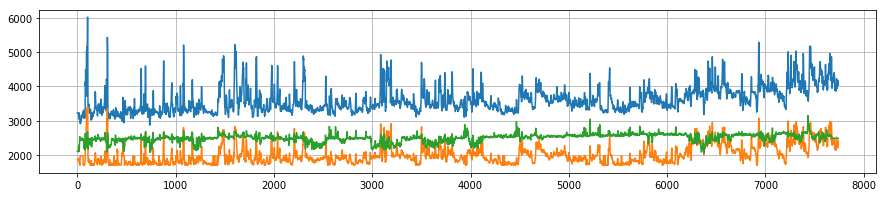

In [14]:
plt.figure(figsize=(15, 3))
plt.plot(VP)
plt.plot(VS)
plt.plot(RHO)
plt.grid()

In [15]:
n = 200

vp = VP[::5][-n-1:]
vs = VS[::5][-n-1:]
rho = RHO[::5][-n-1:]

vp1 = vp[:-1]
vs1 = vs[:-1]
rho1 = rho[:-1]

vp2 = vp[1:]
vs2 = vs[1:]
rho2 = rho[1:]

In [18]:
theta = 30
theta_ = np.ones(n) * theta

X_blind_ = np.vstack([vp1, vs1, rho1, vp2, vs2, rho2, theta_]).T
X_blind = scaler.transform(X_blind_)

y_blind_ = zoeppritz_rpp(vp1, vs1, rho1, vp2, vs2, rho2, theta1=theta)
y_blind = y_blind_.real

In [20]:
np.save('X_blind.npy', X_blind)
np.save('y_blind.npy', y_blind)